In [1]:
import numpy as np
import pandas as pd
import random as r
import math
import os
from datetime import timedelta
import statistics as stats 

import matplotlib.pyplot as plot
import networkx as nx
import seaborn as sns

from pyomo.environ import *
from pyomo.opt import SolverFactory
from gurobipy import GRB

In [2]:
os.chdir(os.getcwd()+'/outputs/3_2_3_evaluate_discrepancies')

In [3]:
K_set = 1
T_set = 10
I_set = 4

In [4]:
dem_dictionary_k = {1: [40000, 80000, 50000]
}

#define supply attributes
#base capacity
#cap_dictionary_supplier_SKU = {1: [9000,11000,10000], #min, max, likely, a,b,c
#                     2: [10000,20000,15000], 
#                     3: [13000,20000,17000],
#                    4: [40000,100000,60000]}

#increase N-95 MG
#cap_dictionary_supplier_SKU = {1: [18000,22000,20000], #min, max, likely, a,b,c
#                     2: [10000,20000,15000], 
#                     3: [13000,20000,17000],
#                     4: [40000,100000,60000]}

#increase SURG
#cap_dictionary_supplier_SKU = {1: [9000,11000,10000], #min, max, likely, a,b,c
#                 2: [10000,20000,15000], 
#                 3: [13000,20000,17000],
#                 4: [50000,110000,70000]}

#increase both
cap_dictionary_supplier_SKU = {1: [18000,22000,20000], #min, max, likely, a,b,c
                 2: [10000,20000,15000], 
                 3: [13000,20000,17000],
                 4: [50000,110000,70000]}

#lead-time
lead_time_dictionary_supplier_SKU = {1: [3,5,4], #min, max, likely, a,b,c
                     2: [1,3,2], 
                     3: [3,5,4],
                     4: [0,2,0]}

#dynamic adj
dynamic_adj_dem = [0.6, 0.85, 1, 1.1, 1.5, 1.6, 1.2, 1.1, 0.5, 0.55] #surge
#dynamic_adj_dem = [0.5, 0.55, 0.6, 1, 1.1, 1.5, 1.6, 1.2, 1.1, 0.85] #original
dynamic_adj_supply = np.zeros(T_set)
for t in range(1, T_set+1):
    if dynamic_adj_dem[t-1] < 1:
        dynamic_adj_supply[t-1] = 1+(1-dynamic_adj_dem[t-1])
    else:
        dynamic_adj_supply[t-1] = 2-dynamic_adj_dem[t-1]

budget = 800000
warehouse_cap_level = 1.5 #time intervals of expected supply needed that can be stored
reliability_level = .75
dynamic = True

#supplier-SKU names
names_supplier_SKU = ['Supplier 1 - SKU: N95-MG', 'Supplier 1 - SKU: N95-N', 
 'Supplier 2 - SKU: SUR-MG', 'Supplier 2 - SKU: SUR-N']

In [5]:
def triangular_dist_demand(a,b,c,prob):
    if prob <= (c-a)/(b-a):
        return(a+((((prob)*(b-a)*(c-a)))**(1/2)))
    else:
        return(b-(((1-prob)*(b-a)*(b-c))**(1/2)))

In [6]:
def triangular_dist_supply(a,b,c,prob):
    if 1-prob <= (c-a)/(b-a):
        return(a+((((1-prob)*(b-a)*(c-a)))**(1/2)))
    else:
        return(b-(((prob)*(b-a)*(b-c))**(1/2)))

In [7]:
def lead_time_dist(a,b,c):
    lead_time_dist_array = np.zeros(T_set+1)
    cum_prob = 0
    t = 0
    
    while t < b+1:
        if t+1 <= a:
            t = t+1 
        elif (a < t+1 & t+1 <= c):
            cum_prob_temp = ((t+1-a)**2)/((b+1-a)*(c-a))
            prob = cum_prob_temp - cum_prob
            lead_time_dist_array[t] = prob
            cum_prob = cum_prob_temp
            t = t+1
        elif c < t+1 & t+1 <= b+1:
            cum_prob_temp = 1-((b+1-(t+1))**2)/((b+1-a)*(b+1-c))
            prob = cum_prob_temp - cum_prob
            lead_time_dist_array[t] = prob
            cum_prob = cum_prob_temp
            t = t+1
    
    return(lead_time_dist_array)

In [8]:
k = 1

#define parameters

###health care commodity metric parameters####
#rank
r_k_dict = {
    1 : 1
}

#quality 
q_k_i_dict = {
    tuple([1,1]) : 1.3,
    tuple([1,2]): 1.2,
    tuple([1,3]): 1.2,
    tuple([1,4]): 1.1
}


####Supply Parameters#####

#lead time (supplier 3 has the lowest lead time)
f_k_i_tDiff_dict = {}
for i in range(1,I_set+1):
    lead_time_dist_array = lead_time_dist(lead_time_dictionary_supplier_SKU.get(i)[0],
                                         lead_time_dictionary_supplier_SKU.get(i)[1],
                                         lead_time_dictionary_supplier_SKU.get(i)[2])
    for t in range(0,T_set+1):
                f_k_i_tDiff_dict[tuple([k,i,t])] = lead_time_dist_array[t]


#incoming orders
o_k_i_t_dict = {}

for k in range(1,K_set+1):
    for i in range(1,I_set+1):
        for t in range(1,T_set+1):
            if t <= 2:
                o_k_i_t_dict[tuple([k,i,t])] = 0 #20000/4 #5000
            else:
                o_k_i_t_dict[tuple([k,i,t])] = 0



#lead time (supplier 1 has the higest capacity)
CAP_k_i_t_dict = {}

for i in range(1,I_set+1):
    cap_temp = triangular_dist_supply(cap_dictionary_supplier_SKU.get(i)[0],
                                      cap_dictionary_supplier_SKU.get(i)[1],
                                      cap_dictionary_supplier_SKU.get(i)[2],
                                      reliability_level)
    if (dynamic == True):
        for t in range(1,T_set+1):
            cap_temp_2 = cap_temp*dynamic_adj_supply[t-1]
            CAP_k_i_t_dict[tuple([k,i,t])] = cap_temp_2
    else:
        for t in range(1,T_set+1):
            CAP_k_i_t_dict[tuple([k,i,t])] = cap_temp

####Demand Parameters####
n_k_init_dict = {
    1 : 0
}


#demand RV
D_k_t_dict = {}
demand_temp = triangular_dist_demand(dem_dictionary_k.get(k)[0],
                                     dem_dictionary_k.get(k)[1],
                                     dem_dictionary_k.get(k)[2],
                                     reliability_level)

if (dynamic == True):
    for t in range(1,T_set+1):
        demand_temp_2 =demand_temp*dynamic_adj_dem[t-1]
        D_k_t_dict[tuple([k,t])] = demand_temp_2
else:
    for t in range(1,T_set+1):
        D_k_t_dict[tuple([k,t])] = demand_temp


#starting inventory
z_k_i_init_dict = {
    tuple([1,1]) : 80000/4,
    tuple([1,2]) : 80000/4,
    tuple([1,3]) : 80000/4,
    tuple([1,4]) : 80000/4
}

#size
s_k_dict = {
    1 : 1
}

#warehouse capacity
h = 80000*warehouse_cap_level 

#cost (supplier 2 has the lowest cost)
c_k_i_dict = {
    tuple([1,1]) : 2,
    tuple([1,2]) : 1.5,
    tuple([1,3]) : 1,
    tuple([1,4]) : .8
}

b = budget

In [9]:
model = ConcreteModel()

#####define sets#######
model.K = Set(initialize = range(1,K_set+1))
model.I = Set(initialize = range(1,I_set+1))
model.T = Set(initialize = range(1,T_set+1))
model.T_0 = Set(initialize = range(0,T_set+1))

####initialize parameters####

def rank_param_initialize(model, k):
    return(r_k_dict.get(k))

model.r_k = Param(model.K, initialize = rank_param_initialize)

def discount_param_initialize(model, k, t):
    discount_temp = 1/model.r_k[k]
    return(1/((1+discount_temp)**(t)))

model.tau_k_t = Param(model.K, model.T_0, initialize = discount_param_initialize)

#model.tau_k_t.pprint()

def quality_param_initialize(model, k, i):
    return(q_k_i_dict.get(tuple([k,i])))

model.q_k_i = Param(model.K, model.I, initialize = quality_param_initialize)

#model.q_k_i.pprint()

def delay_dist_param_initialize(model, k, i, t):
    return(f_k_i_tDiff_dict.get(tuple([k,i,t])))

model.f_k_i_tDiff = Param(model.K, model.I, model.T_0, 
                          initialize = delay_dist_param_initialize)

#model.f_k_i_tDiff.pprint()

def incoming_orders_initialize(model, k, i, t):
    return(o_k_i_t_dict.get(tuple([k,i,t])))

model.o_k_i_t = Param(model.K, model.I, model.T, initialize = incoming_orders_initialize)

#model.o_k_i_t.pprint()

def supplier_cap_param_initialize(model, k, i, t):
    return(CAP_k_i_t_dict.get(tuple([k,i,t])))

model.cap_k_i_t = Param(model.K, model.I, model.T, initialize = supplier_cap_param_initialize)

#model.cap_k_i_t.pprint()

def unfulfilled_demand_param_initialize(model, k):
    return(n_k_init_dict.get(k))

model.n_k_intialize = Param(model.K, initialize = unfulfilled_demand_param_initialize)

#model.n_k_intialize.pprint()

#assume preparing for one sd above the mean
def demand_param_initialize(model, k, t):
    return(D_k_t_dict.get(tuple([k,t])))

model.d_k_t = Param(model.K, model.T, initialize = demand_param_initialize)

#model.d_k_t.pprint()

def beg_inv_param_initialize(model, k, i):
    return(z_k_i_init_dict.get(tuple([k,i])))

model.z_k_i_init = Param(model.K, model.I, initialize = beg_inv_param_initialize)

#model.z_k_i_init.pprint()

def item_size_param_initialize(model, k):
    return(s_k_dict.get(k))

model.s_k = Param(model.K, initialize = item_size_param_initialize)

#model.s_k.pprint()

def warehouse_cap_param_initialize(model):
    return(h)

model.h = Param(initialize = h)

#model.h.pprint()

def cost_param_initialize(model, k, i):
    return(c_k_i_dict.get(tuple([k,i])))

model.c_k_i = Param(model.K, model.I, initialize = cost_param_initialize)

#model.c_k_i.pprint()

def budget_param_initialize(model):
    return(b)

model.b = Param(initialize = budget_param_initialize)

#model.b.pprint()

####initialize variables####
model.x_k_i_t = Var(model.K, model.I, model.T, within = NonNegativeReals) #amount ordered
model.y_k_i_t = Var(model.K, model.I, model.T, within = NonNegativeReals) #amount recieved
model.z_k_i_t = Var(model.K, model.I, model.T, within = NonNegativeReals)
model.n_k_t = Var(model.K, model.T, model.T_0, within = NonNegativeReals)
model.m_k_i_t = Var(model.K, model.I, model.T, model.T_0, within = NonNegativeReals)

In [10]:
#def initialize_objective(model):
model.Objective = Objective(expr = 
                            (sum(model.q_k_i[k,i]*sum(model.tau_k_t[k,t-1]*model.m_k_i_t[k,i,t, t_req] 
                                                      for t in model.T for t_req in range(0,t+1)) 
                                 for i in model.I for k in model.K)),
                            sense = maximize)

In [11]:
def incoming_orders_constraint_initialize(model, k, i, t):
    return(model.y_k_i_t[k,i,t] - 
           sum(model.f_k_i_tDiff[k, i, t-t_ordered_time]*model.x_k_i_t[k,i,t_ordered_time] 
               for t_ordered_time in range(1,t+1)) - model.o_k_i_t[k,i,t] == 0)

model.incoming_ordered_constraint = Constraint(model.K, model.I, model.T, 
                                               rule = incoming_orders_constraint_initialize)

In [12]:
def supplier_constraint_initialize(model, k, i, t):
    return(model.x_k_i_t[k,i,t] <= model.cap_k_i_t[k,i,t])

model.supplier_constraint = \
Constraint(model.K, model.I, model.T, rule = supplier_constraint_initialize)

In [13]:
def initalize_unsatisfied_demand_constraint_initialize(model, k):
    return(model.n_k_t[k,1,0] == model.n_k_intialize[k])

model.initalize_unsatisfied_demand_constraint= \
Constraint(model.K, rule = initalize_unsatisfied_demand_constraint_initialize)

In [14]:
def calculate_unsatisfied_demand_constraint_initialize(model,k,t, t_req):
    if (t == t_req):
        return(model.n_k_t[k,t,t_req] == model.d_k_t[k,t] - \
               sum(model.m_k_i_t[k,i,t,t_req] for i in model.I))
    elif (t_req < t & t > 1):
        return(model.n_k_t[k,t,t_req] == model.n_k_t[k,t-1,t_req] -\
               sum(model.m_k_i_t[k,i,t,t_req] for i in model.I))
    else:
        return(Constraint.Skip)

model.calculate_unsatisfied_demand_constraint = \
Constraint(model.K, model.T, model.T_0, rule = calculate_unsatisfied_demand_constraint_initialize)

In [15]:
def beggining_inventory_constraint_initialize(model, k, i):
    return(model.z_k_i_t[k,i,1] == model.z_k_i_init[k,i])
    
model.beggining_inventory_constraint = Constraint(model.K, model.I, 
                                                  rule = beggining_inventory_constraint_initialize)

In [16]:
def calculate_available_inventory_constraint_initialize(model, k, i, t):
    if (t > 1):
        return(model.z_k_i_t[k,i,t] - model.z_k_i_t[k,i,t-1] - model.y_k_i_t[k,i,t-1] + 
               sum(model.m_k_i_t[k,i,t-1, t_hat] for t_hat in model.T_0) == 0)
    else:
        return(Constraint.Skip)
    
model.calculate_available_inventory_constraint = Constraint(model.K, model.I, model.T,
                                                            rule = 
                                                            calculate_available_inventory_constraint_initialize)

In [17]:
def cannot_fulfill_more_than_available_constraint_initialize(model, k,i,t):
    return(sum(model.m_k_i_t[k,i,t, t_hat] for t_hat in model.T_0) - model.z_k_i_t[k,i,t] <= 0)

model.cannot_fulfill_more_than_available_constraint = \
Constraint(model.K, model.I, model.T, rule = cannot_fulfill_more_than_available_constraint_initialize)

In [18]:
def warehouse_capacity_constraint_initialize(model, t):
    return(sum(model.s_k[k]*model.z_k_i_t[k,i,t] for k in model.K for i in model.I) <= model.h)

model.warehouse_capacity_constraint = \
Constraint(model.T, rule = warehouse_capacity_constraint_initialize)

In [19]:
def budget_constraint_initialize(model):
    return(sum(model.c_k_i[k,i]*model.x_k_i_t[k,i,t] 
               for k in model.K for i in model.I for t in model.T) 
           <= model.b)

model.budget_constraint = \
Constraint(rule = budget_constraint_initialize)

In [20]:
opt = SolverFactory('gurobi_persistent')
opt.set_instance(model)
opt.solve(model)

Using license file /Users/chelseagreene/gurobi.lic
Academic license - for non-commercial use only - expires 2021-02-20


{'Problem': [{'Name': 'unknown', 'Lower bound': 172220.86450499756, 'Upper bound': 172220.86450499756, 'Number of objectives': 1, 'Number of constraints': 236, 'Number of variables': 670, 'Number of binary variables': 0, 'Number of integer variables': 0, 'Number of continuous variables': 670, 'Number of nonzeros': 1610, 'Sense': -1, 'Number of solutions': 1}], 'Solver': [{'Name': 'Gurobi 9.10', 'Status': 'ok', 'Wallclock time': 0.002043008804321289, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.'}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [21]:
#extract ordering df
ordered_df = pd.DataFrame(list(model.x_k_i_t.extract_values().items()),columns = ['sets','units_to_order'])
ordered_df.loc[:,'item_type']=ordered_df.sets.map(lambda x:x[0])
ordered_df.loc[:,'supplier']=ordered_df.sets.map(lambda x:x[1])
ordered_df.loc[:,'time_interval']=ordered_df.sets.map(lambda x:x[2])

In [22]:
#extract costs
cost_df = pd.DataFrame(list(model.c_k_i.extract_values().items()),columns = ['sets','cost'])
cost_df.loc[:,'supplier']=cost_df.sets.map(lambda x:x[1])
cost_df = cost_df[['supplier', 'cost']]

In [23]:
#extract expected arrivals df
recieved_df = pd.DataFrame(list(model.y_k_i_t.extract_values().items()),columns = ['sets','expected_units_recieved'])
recieved_df.loc[:,'item_type']=recieved_df.sets.map(lambda x:x[0])
recieved_df.loc[:,'supplier']=recieved_df.sets.map(lambda x:x[1])
recieved_df.loc[:,'time_interval']=recieved_df.sets.map(lambda x:x[2])

In [24]:
#extract expected fulfilled df
fulfilled_df = pd.DataFrame(list(model.m_k_i_t.extract_values().items()),columns = ['sets','units_fulfilled'])
fulfilled_df.loc[:,'item_type']=fulfilled_df.sets.map(lambda x:x[0])
fulfilled_df.loc[:,'supplier']=fulfilled_df.sets.map(lambda x:x[1])
fulfilled_df.loc[:,'time_interval']=fulfilled_df.sets.map(lambda x:x[2])
fulfilled_df.loc[:,'time_interval_req']=fulfilled_df.sets.map(lambda x:x[3])
fulfilled_df['delay'] = fulfilled_df['time_interval'] - fulfilled_df['time_interval_req']

In [25]:
#extract expected available df
available_df = pd.DataFrame(list(model.z_k_i_t.extract_values().items()),columns = ['sets','units_available'])
available_df.loc[:,'item_type']=available_df.sets.map(lambda x:x[0])
available_df.loc[:,'supplier']=available_df.sets.map(lambda x:x[1])
available_df.loc[:,'time_interval']=available_df.sets.map(lambda x:x[2])

In [26]:
#extract expected unsatisfied df
unsatisfied_df = pd.DataFrame(list(model.n_k_t.extract_values().items()),columns = ['sets','units_unsatisfied'])
unsatisfied_df.loc[:,'item_type']=unsatisfied_df.sets.map(lambda x:x[0])
unsatisfied_df.loc[:,'time_interval']=unsatisfied_df.sets.map(lambda x:x[1])

In [27]:
demand_df = pd.DataFrame(list(model.d_k_t.extract_values().items()), columns = ['sets', 'demand_in_units'])
demand_df.loc[:,'item_type']=demand_df.sets.map(lambda x:x[0])
demand_df.loc[:,'time_interval']=demand_df.sets.map(lambda x:x[1])

In [28]:
ordered_and_recieved_df = ordered_df[['item_type', 'supplier', 'time_interval', 'sets']]
ordered_and_recieved_df = ordered_and_recieved_df.merge(recieved_df[['sets', 'expected_units_recieved']],
                                                        on='sets', how='left')
ordered_and_recieved_df = ordered_and_recieved_df.merge(ordered_df[['sets', 'units_to_order']],
                                                        on='sets', how='left')

ordered_and_recieved_df = ordered_and_recieved_df[['item_type', 'supplier', 
                                                   'time_interval','units_to_order', 
                                                   'expected_units_recieved']]

ordered_and_recieved_df['units_to_order'] = (round(ordered_and_recieved_df['units_to_order'])).astype(int)
ordered_and_recieved_df['expected_units_recieved'] = (round(ordered_and_recieved_df['expected_units_recieved'])).astype(int)

In [29]:
#os.chdir(results_dir)
ordered_and_recieved_df.to_csv('ordering_and_recieving_schedule.csv')

recieved_df.to_csv('recieving_schedule.csv')
ordered_df.to_csv('ordering_schedule.csv')

In [30]:
#for k in range(1,K+1):
unsatisfied_temp_df = unsatisfied_df[unsatisfied_df['item_type'] == 1].groupby(['time_interval'])['units_unsatisfied']\
.sum().reset_index()
fulfilled_temp_df = fulfilled_df[fulfilled_df['item_type'] == 1].groupby(['time_interval'])["units_fulfilled"]\
.sum().reset_index()
available_temp_df = available_df[available_df['item_type'] == 1].groupby(['time_interval'])["units_available"]\
.sum().reset_index()

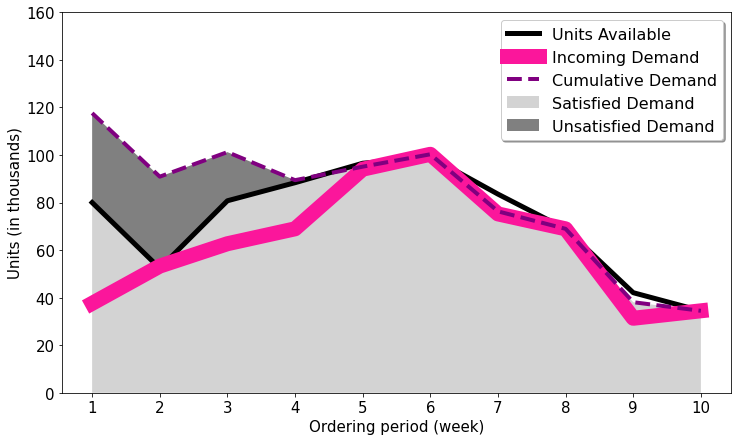

In [31]:
temp_all = unsatisfied_temp_df[['time_interval', 'units_unsatisfied']].\
merge(fulfilled_temp_df, how='inner', on='time_interval')

fig2, ax2 = plot.subplots(figsize=(12,7))

ax2.plot(available_temp_df['time_interval'], 
          (available_temp_df['units_available'])/1000, 
          label='Units Available',
          color ="black",
         linewidth=5) 

ax2.plot(demand_df['time_interval'], 
         (demand_df['demand_in_units'])/1000 , 
         label='Incoming Demand', #\n additional demand \nplus unfulfilled demand\nfrom the day before',
         linewidth=15,
         color = "#fb169b")

ax2.plot(demand_df['time_interval'], 
         (temp_all['units_fulfilled']+temp_all['units_unsatisfied'])/1000, 
         label='Cumulative Demand',
         linewidth=4,
         color = 'purple',
         linestyle='dashed')

# Your x and y axis
x=range(1,T_set+1)
y=[temp_all['units_fulfilled']/1000, temp_all['units_unsatisfied']/1000]
 
# use a known color palette (see..)
pal = ["#D3D3D3", "#808080"]
plot.stackplot(x,y, labels=['Satisfied Demand', 'Unsatisfied Demand'], colors=pal)
plot.legend(loc='upper right')
plot.xticks(fontsize= 15)
plot.yticks(fontsize= 15)
ax2.xaxis.set_ticks(np.arange(1, T_set+1, 1))
ax2.yaxis.set_ticks(np.arange(0, 180, 20))

ax2.set_xlabel('Ordering period (week)', fontsize=15)
ax2.set_ylabel('Units (in thousands)', fontsize=15)
#ax2.set_title('Available, Unsatisfied, and Satisfied Units of Masks (k=1) \n summed over all suppliers (i) at each Time Interval (t)\
#\n medium supplier risk, medium demand reliability', fontsize='xx-large')
#ax2.set_title('Available, Unsatisfied, and Satisfied Units of Masks during each Time Interval\
#\n Assuming Average (no variation) Supplier Capacity and Demand Projections, \n \
#and a Budget of \$80,000 over 10 Weeks', fontsize=24)
ax2.legend(loc='upper right', shadow=True, fontsize=16)

#plot.savefig('initial_forecast.jpg')
#plot.savefig('revised_forecast.jpg')

In [32]:
temp_all = unsatisfied_temp_df[['time_interval', 'units_unsatisfied']].\
merge(fulfilled_temp_df, how='inner', on='time_interval')

In [33]:
temp_all['percent_unsatisfied'] = temp_all['units_unsatisfied']/(temp_all['units_fulfilled'] + temp_all['units_unsatisfied'])
temp_all['stacked'] = temp_all['units_fulfilled'] + temp_all['units_unsatisfied']

In [34]:
units = []
name = []
time_interval = []

In [35]:
for i in fulfilled_df.index:
    units.append(fulfilled_df['units_fulfilled'].iloc[i])
    time_interval.append(fulfilled_df['time_interval'].iloc[i])
    if (fulfilled_df['supplier'].iloc[i] == 1):
        name.append('SKU: N95-MG')
    elif (fulfilled_df['supplier'].iloc[i] == 2):
        name.append('SKU: N95-N')
    elif (fulfilled_df['supplier'].iloc[i] == 3):
        name.append('SKU: SUR-MG')
    else:
        name.append('SKU: SUR-N')

        
for i in unsatisfied_df.index:
    units.append(unsatisfied_df['units_unsatisfied'].iloc[i])
    time_interval.append(unsatisfied_df['time_interval'].iloc[i])
    name.append('unsatisfied_demand')

In [36]:
stacked_temp = pd.DataFrame(list(zip(name, time_interval, units)), 
                    columns =['name', 'time_interval', 'units']).groupby(['time_interval', 'name']).sum()\
.reset_index()
stacked_temp['units'] = stacked_temp['units']/1000

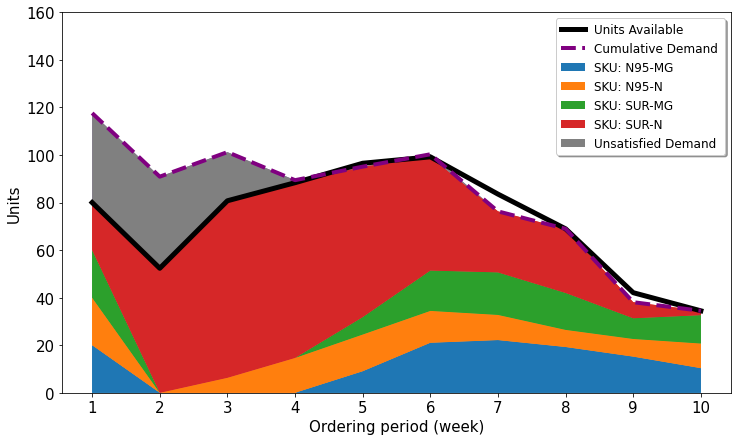

In [37]:
fig2, ax3 = plot.subplots(figsize=(12,7))

ax3.plot(available_temp_df['time_interval'], 
          available_temp_df['units_available']/1000,  
          label='Units Available',
          color ="black",
         linewidth=5) 

#ax3.plot(demand_df['time_interval'], 
#         (demand_df['demand_in_units'])/1000 , 
#         label='incoming demand', #\n additional demand \nplus unfulfilled demand\nfrom the day before',
#         linewidth=5,
#         color = "#fb169b")

ax3.plot(demand_df['time_interval'], 
         (temp_all['units_fulfilled']+temp_all['units_unsatisfied'])/1000, 
         label='Cumulative Demand',
         linewidth=4,
         color = "purple",
         linestyle='dashed')

# Your x and y axis
x=range(1,T_set+1)
y=[stacked_temp[stacked_temp['name'] == 'SKU: N95-MG']['units'], stacked_temp[stacked_temp['name'] == 'SKU: N95-N']['units'],
  stacked_temp[stacked_temp['name'] == 'SKU: SUR-MG']['units'], stacked_temp[stacked_temp['name'] == 'SKU: SUR-N']['units'],
  stacked_temp[stacked_temp['name'] == 'unsatisfied_demand']['units']]
 
# use a known color palette (see..)
pal = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', "808080"]
ax3.stackplot(x,y)#, labels=['High Capacity R US (Surgical Masks)', 'Affordable PPE (Cloth Masks)', 'Speedy Industries (Surgical Masks)', 
                            #'High Quality Inc. (N95 Masks)', 'Unsatisfied Demand '], colors=pal)#, alpha=0.4)
ax3.stackplot(x,y, labels=['SKU: N95-MG', 'SKU: N95-N', 'SKU: SUR-MG', 
                            'SKU: SUR-N', 'Unsatisfied Demand '], colors=pal)#, alpha=0.4)

plot.xticks(fontsize= 15)
plot.yticks(fontsize= 15)

ax3.xaxis.set_ticks(np.arange(1, T_set+1, 1))
ax3.yaxis.set_ticks(np.arange(0, 180, 20))
#ax3.yaxis.set_ticks(np.arange(0, 100000, 10000))


ax3.set_xlabel('Ordering period (week)', fontsize=15)
ax3.set_ylabel('Units', fontsize=15)
#ax3.set_title('Available, Unsatisfied, and Satisfied Units of Masks from each Supplier during each Time Interval\
#\nAssuming Average (no variation) Supplier Capacity and Demand Projections, \n \
#and a Budget of \$80,000 over 10 Weeks', fontsize=24)
ax3.legend(loc='upper right', shadow=True, fontsize='large')

#plot.savefig('revised_forecast_original_suppliers.jpg')
plot.savefig('revised_forecast_additional_suppliers.jpg')

In [38]:
I_set = 4

In [39]:
### ordering and recieving picture
pos_dict_all = {}
label_dict_all = {}
color_dict_all = {}
G_dict_all = {}
edge_labels_dict_all = {}